In [1]:
# training a small FGNET on MNIST data

In [2]:
from __future__ import print_function

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import torch_helper_lib as th

import json
import pickle

In [4]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [6]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [7]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 2048

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 0
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


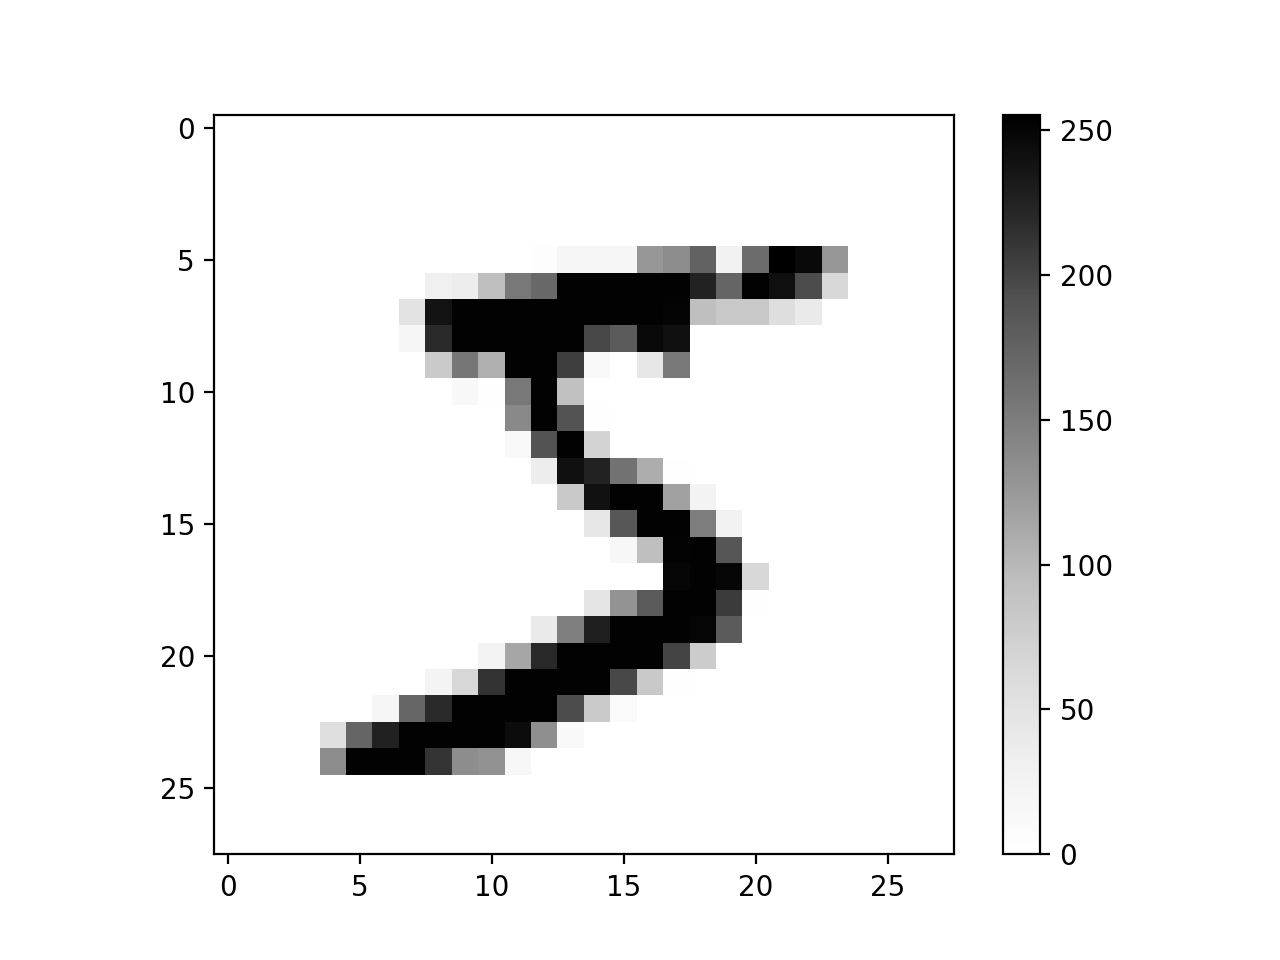

In [8]:
# show an example
print("Shape:", mnist_train_loader.dataset.train_data.shape)
x = mnist_train_loader.dataset.train_data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.train_labels[1]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [9]:
# # check data loader values post transform (random because the loader shuffles)
# for batch_idx, (data, target) in enumerate(mnist_train_loader):
#     x = data[0][0].numpy()
#     print(np.shape(x))
#     print(x)
#     plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
#     plt.colorbar()
#     plt.show()
#     break

In [10]:
# # include number of sigs in lmbda?
# t_params = sum(p.numel() for p in fgn_model.parameters() if p.requires_grad)
# print(t_params)
# lmbda = 1.0/(len(mnist_train_loader.dataset)+t_params)
# print(lmbda)


# # training loss function
# def training_loss_func(model, output, target):
    
#     # normal NLL loss
#     nll_loss = F.nll_loss(output, target.long())
# #     print(nll_loss)

# #     sum of sigma squares loss
# #     sig_loss = lmbda*torch.sum(model.fl.sigs)
# #     sig_loss = lmbda*torch.sum(model.state_dict()['fl.sigs'])
# #     print(type(sig_loss.grad_fn))
# #     sigs  = torch.nn.Parameter(torch.Tensor(), requires_grad = True).to(device)
# #     print(type(sigs.grad_fn))

#     for p in model.named_parameters():
#         if 'sigs' in p[0]:
#             try:
#                 sig_loss += torch.sum(p[1]**2)
#             except:
#                 sig_loss = torch.sum(p[1]**2)
# #             sigs = torch.cat((sigs, fgn_model.state_dict()[key]))
# #     print(type(sigs.grad_fn))
#     sig_loss = lmbda*sig_loss
# #     print(type(sig_loss.grad_fn))


#     return 1.0*nll_loss + 1.0*sig_loss

# # number of correct pred function for fgnet
# def fgn_pred_func(output, target):
#     pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#     correct = pred.eq(target.long().view_as(pred)).sum().item()
#     return correct

In [11]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 0.1*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

# loss functions
def l2_loss(model):
    # sum of w^2 for regularizer 
    for p in model.named_parameters():
        if ('weight' in p[0]) or ('bias' in p[0]):
            try:
                l2 += torch.sum(p[1]**2)
            except:
                l2 = torch.sum(p[1]**2)          
    return l2

def sigmas_loss(model):
    # sum of sigma^2 for regularizer 
    for p in model.named_parameters():
        if 'sigs' in p[0]:
            try:
                sig_loss += torch.sum(p[1]**2)
            except:
                sig_loss = torch.sum(p[1]**2)
                
    return sig_loss


def fgn_cross_ent_loss(model, output, target):
    # normal Cross entropy loss
    cent_loss = F.cross_entropy(output, target.long())
    # normal l2 loss
    l2 = l2_loss(model)
    #sigma loss
    sig_loss = sigmas_loss(model)
    
    return cent_loss + lmbda_l2*l2 + lmbda_sigs*sig_loss


lambda for l2 loss 6.66666666667e-06
lambda for sigs^2 loss 6.66666666667e-07


In [12]:
# create model to be trained
size = [32,32] # should get 90% acc minimum
fgn_model = th.Feedforward_FGN_net(28*28,10,size).to(device)

In [13]:
print("Final layer sigmas:",fgn_model.fl.sigs)
print("Final layer centers:",fgn_model.fl.centers)
print("Final layer weights:",fgn_model.fl.weights)

Final layer sigmas: Parameter containing:
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], device='cuda:0',
       requires_grad=True)
Final layer centers: Parameter containing:
tensor([[-2.0707, -1.1943,  0.4113, -1.4236, -0.0320,  1.4712, -0.1443,  0.8638,
          0.5328, -0.3833,  0.0224, -0.6062,  0.7320, -0.3736, -0.7250,  1.3107,
         -0.5097, -0.4144,  0.3374, -0.7202,  2.5557, -0.6551, -0.9337, -1.4616,
         -0.5342, -1.1915, -0.0505,  0.9714,  1.3378,  0.1654, -0.0128,  1.7033],
        [ 0.2306,  0.8459, -0.6002, -0.0620, -0.4748,  0.2450,  0.3663,  0.1907,
          1.1683, -0.9962, -1.1683,  0.2939,  1.2359,  0.1880,  0.9101,  0.8824,
          0.2140, -0.3422,  1.6388,  0.5261, -0.7001,  0.8539, -0.3513,  0.2521,
          2.8784, -0.2278, -1.4121,  0.6593, -0.4207, -1.8235,  1.2032, -0.7905],
        [-1.1548, -0.8960,  0.8127,  1.2015,  1.5153, -2.0522,  0.8431, -0.7266,
         -1.0891, -1.4950,  0.1916, -0.0291,  2.2719,  0.3692, -0.8683,  0.3131,
         -

In [14]:
# print(fgn_model.state_dict())

In [15]:
# some needed parameters
# train_epochs = 3 

In [16]:
# optimizer for all params except sigma
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01, momentum=0.5, nesterov=True)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01)
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()), momentum=0.8)


# NON FILTER IS POSSIBLY BUGGED optimizer = optim.RMSprop([p for name,p in fgn_model.named_parameters() 
#                            if p.requires_grad 
#                            and 'sigs' not in name 
#                            and 'hidden' in name], 
#                           momentum=0.9)
# optimizer = optim.SGD([p for name,p in fgn_model.named_parameters() if p.requires_grad and 'sigs' in name], lr=0.99, momentum=0.8, nesterov=True)

In [17]:
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [18]:
fgn_train_res = []

In [19]:
train_epochs = 15
latest_res = th.train(fgn_model, device, mnist_train_loader, 
                      fgn_cross_ent_loss, fgn_optimizer, epochs=train_epochs, save_hist=2, verbose=True, 
                      pred_func=th.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 41.0960, Accuracy: 19791/60000 (33%)
Test set - Average loss: 37.6874, Accuracy: 2664/10000 (27%)
Epoch 1 Train set - Average loss: 34.6677, Accuracy: 41196/60000 (69%)
Test set - Average loss: 33.4741, Accuracy: 4952/10000 (50%)
Epoch 2 Train set - Average loss: 31.0913, Accuracy: 48102/60000 (80%)
Test set - Average loss: 29.8576, Accuracy: 7356/10000 (74%)
Epoch 3 Train set - Average loss: 28.3805, Accuracy: 50299/60000 (84%)
Test set - Average loss: 27.4088, Accuracy: 7480/10000 (75%)
Epoch 4 Train set - Average loss: 26.0763, Accuracy: 51709/60000 (86%)
Test set - Average loss: 25.1636, Accuracy: 8140/10000 (81%)
Epoch 5 Train set - Average loss: 24.0481, Accuracy: 52410/60000 (87%)
Test set - Average loss: 23.3517, Accuracy: 7855/10000 (79%)
Epoch 6 Train set - Average loss: 22.2199, Accuracy: 52919/60000 (88%)
Test set - Average loss: 21.4782, Accuracy: 8409/10000 (84%)
Epoch 7 Train set - Average loss: 20.5360, Accuracy: 53496/60000 (89%)
Test 

In [20]:
def update_histories(dict1, dict2):
    # ugly hackish way of updating dicts (side effect, not true recursion)
    # used fo running multiple trainings in a row
    for key in dict1.keys():
        if isinstance(dict1[key], (list,)):
            print("Extending:", key)
            dict1[key].extend(dict2[key])
        elif isinstance(dict1[key], dict):
            print("inner dict:", key)
            update_histories(dict1[key], dict2[key])
        else:
            print("other:", key)

if len(fgn_train_res)>0 :
    update_histories(fgn_train_res, latest_res)
else:
    fgn_train_res = latest_res

In [21]:
print("Final layer sigmas:",fgn_model.fl.sigs)
print("Final layer centers:",fgn_model.fl.centers)

Final layer sigmas: Parameter containing:
tensor([5.3708, 5.6605, 5.3964, 5.2503, 5.0927, 5.1192, 5.2336, 5.2970, 4.7366,
        5.1862], device='cuda:0', requires_grad=True)
Final layer centers: Parameter containing:
tensor([[-1.8671, -1.0284, -0.1950, -1.1616,  0.2657,  1.0715, -0.1165,  0.8195,
          0.4823, -0.4785,  1.1490, -0.5156,  0.5288, -0.1168, -0.5612,  1.1039,
         -0.1909, -0.5763,  0.8767, -0.6561,  2.2947, -0.5900, -0.3871, -1.3970,
         -0.6034, -1.0582,  0.1487,  0.5677,  1.1646,  0.1645, -0.0203,  1.4186],
        [ 0.0064,  0.7242, -0.2816, -0.1800, -0.3569,  0.0834,  0.3746,  0.1252,
          0.8653, -0.6966, -0.8319,  0.2609,  1.3047,  0.3993,  0.3265,  0.8271,
          0.0594, -0.2066,  1.1182,  0.5767, -0.5857,  0.1338, -0.5336, -0.0622,
          2.4987, -0.3428, -1.2290,  0.4015, -0.3981, -1.4876,  0.9521, -0.9630],
        [-1.0303, -0.8388,  0.1650,  0.8213,  1.2813, -1.8494,  0.6947, -0.5375,
         -0.5677, -1.4143,  0.3664,  0.0189,  2.04

In [22]:
for m in fgn_model.named_parameters():
    if 'sigs' in m[0]:
        print(m[0])
        print(m[1])

hidden_layers.1.sigs
Parameter containing:
tensor([10.1262,  9.8827,  9.9797,  9.3949, 10.0416,  9.5338,  9.4009, 10.0420,
        13.3227, 11.6719,  9.3176,  9.3953,  9.4130, 10.5627,  8.8089,  9.4010,
         9.5519,  9.7042, 10.0091,  9.6372, 12.1562, 14.1726, 11.3141, 11.6214,
        11.4809, 11.3978,  9.7022, 10.0726,  9.4007,  9.7601, 11.8731, 12.2226],
       device='cuda:0', requires_grad=True)
hidden_layers.4.sigs
Parameter containing:
tensor([4.2326, 5.8667, 3.9222, 5.1359, 5.2434, 5.9206, 5.4608, 3.0926, 3.1943,
        5.5325, 5.9468, 4.9489, 5.1432, 5.5760, 5.2750, 4.0683, 2.7778, 4.7514,
        3.5791, 5.1611, 4.9564, 5.9574, 3.8797, 4.9364, 5.3884, 4.5672, 2.6892,
        5.3066, 5.7579, 5.7025, 5.8932, 6.6013], device='cuda:0',
       requires_grad=True)
fl.sigs
Parameter containing:
tensor([5.3708, 5.6605, 5.3964, 5.2503, 5.0927, 5.1192, 5.2336, 5.2970, 4.7366,
        5.1862], device='cuda:0', requires_grad=True)


In [23]:
for m in fgn_model.named_parameters():
    if 'centers' in m[0]:
        print(m[0])
        print(m[1])

hidden_layers.1.centers
Parameter containing:
tensor([[ 0.3341, -0.2553,  0.0801,  ..., -0.2125,  2.4315,  0.1065],
        [ 0.0163, -0.1531,  0.4183,  ..., -1.1672, -1.3351,  0.8211],
        [-0.3836,  0.6442,  1.5291,  ...,  0.1484,  0.6875, -0.9532],
        ...,
        [ 1.5551,  0.4276,  0.3630,  ..., -0.5396, -0.3198,  0.8340],
        [ 0.2775, -0.1015, -0.5635,  ..., -0.3530, -0.3408, -0.2757],
        [-0.6191,  0.5394,  0.1061,  ..., -0.2478,  0.2569, -0.6120]],
       device='cuda:0', requires_grad=True)
hidden_layers.4.centers
Parameter containing:
tensor([[-1.3381,  1.6017, -1.8510,  ...,  0.8293, -0.8016,  0.9531],
        [-1.0085,  0.9458, -0.1533,  ..., -0.1730,  0.1704,  1.4638],
        [-0.1620,  0.6077, -3.0824,  ..., -1.1986, -1.4042,  0.5837],
        ...,
        [ 0.8137,  1.5687,  0.6476,  ...,  0.6780,  1.2364, -0.1236],
        [ 0.8222, -0.2358, -0.3358,  ...,  0.7958,  2.0793,  1.2112],
        [ 0.6879, -0.2529,  0.4878,  ...,  0.6798,  0.5459,  1.1527

<IPython.core.display.Javascript object>


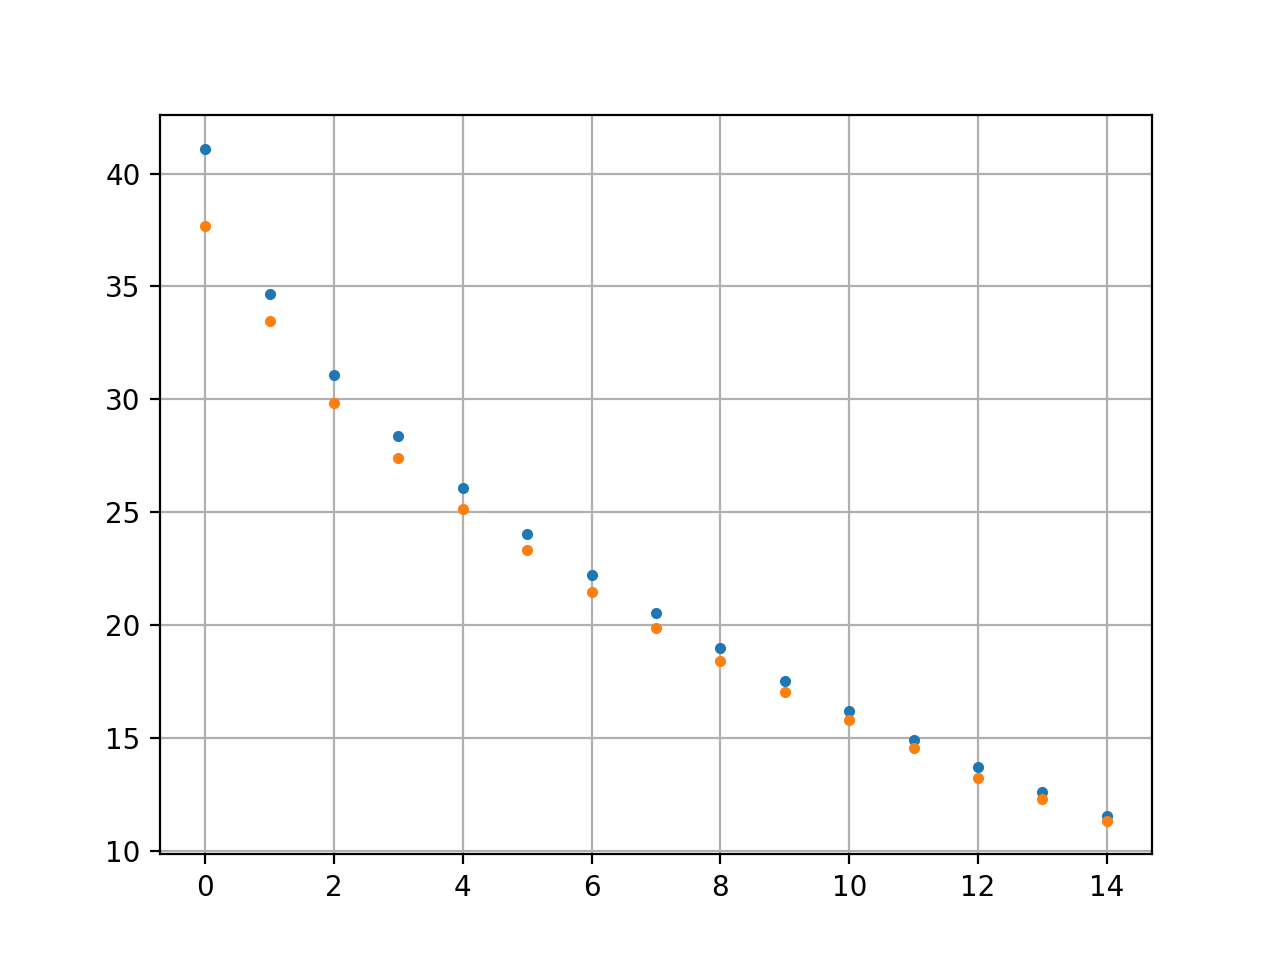

<IPython.core.display.Javascript object>


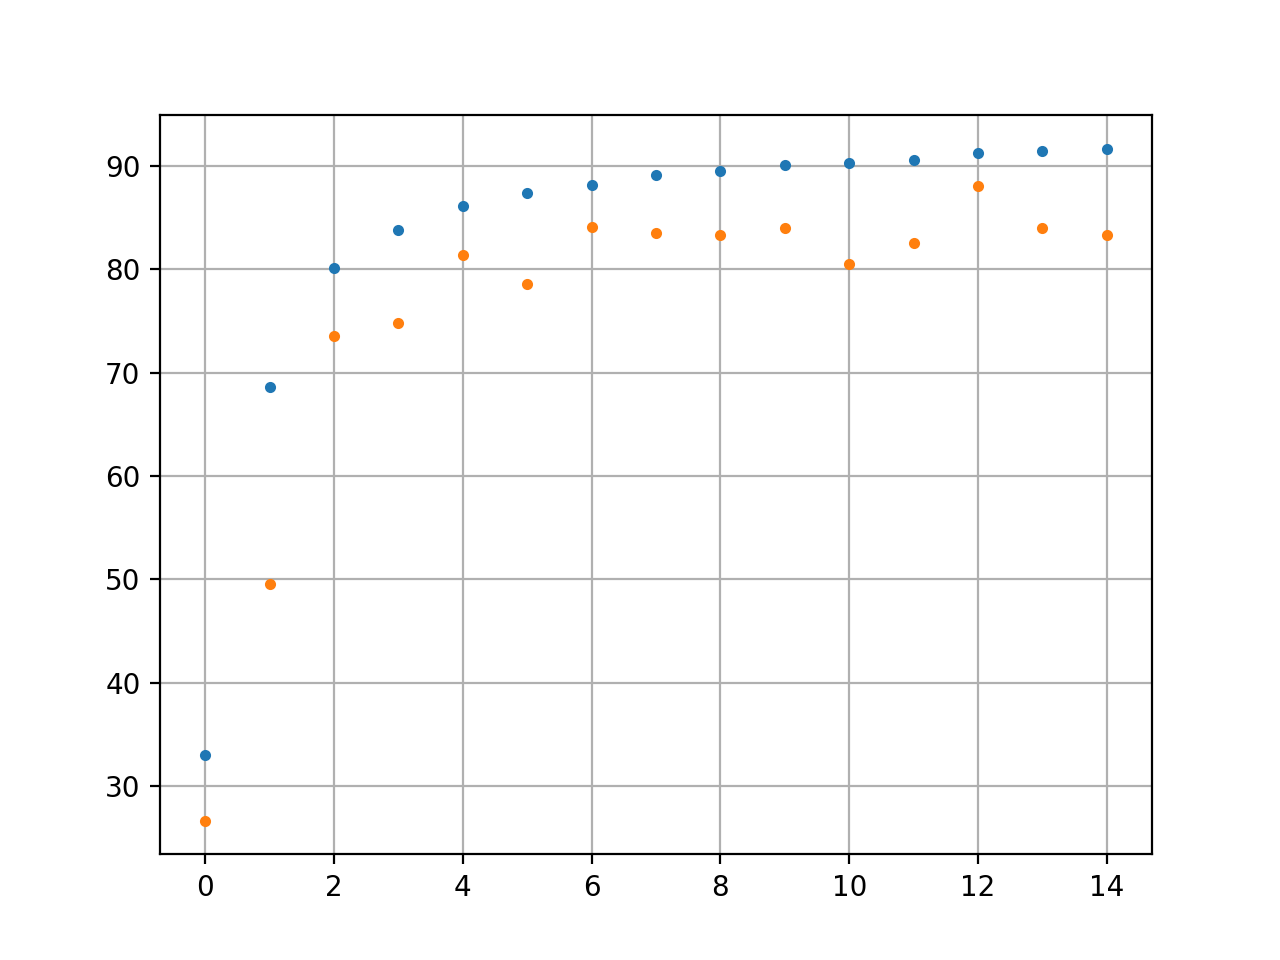

In [24]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

hidden_layers.1.sigs


<IPython.core.display.Javascript object>


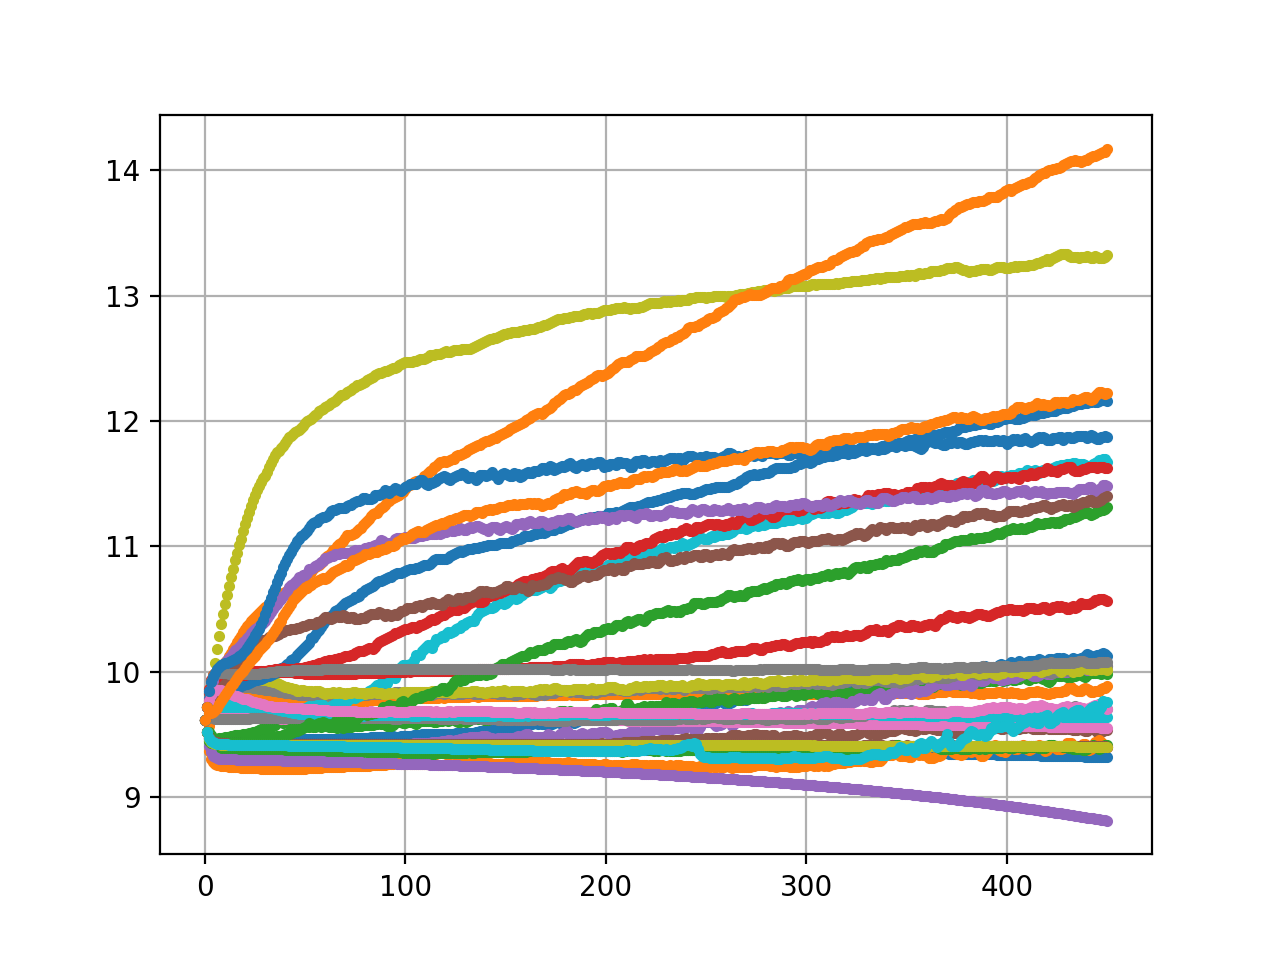

hidden_layers.4.sigs


<IPython.core.display.Javascript object>


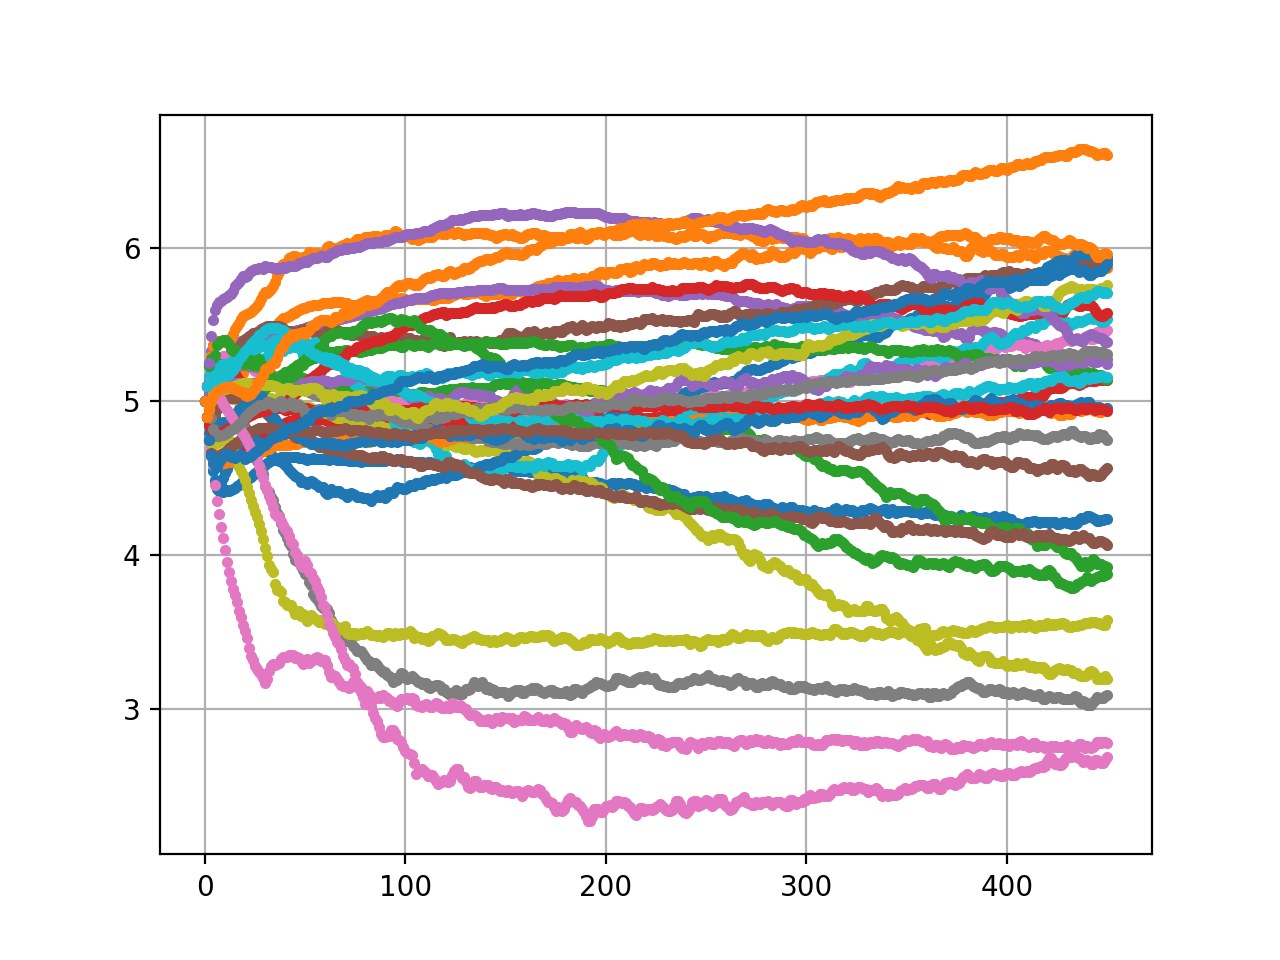

fl.sigs


<IPython.core.display.Javascript object>


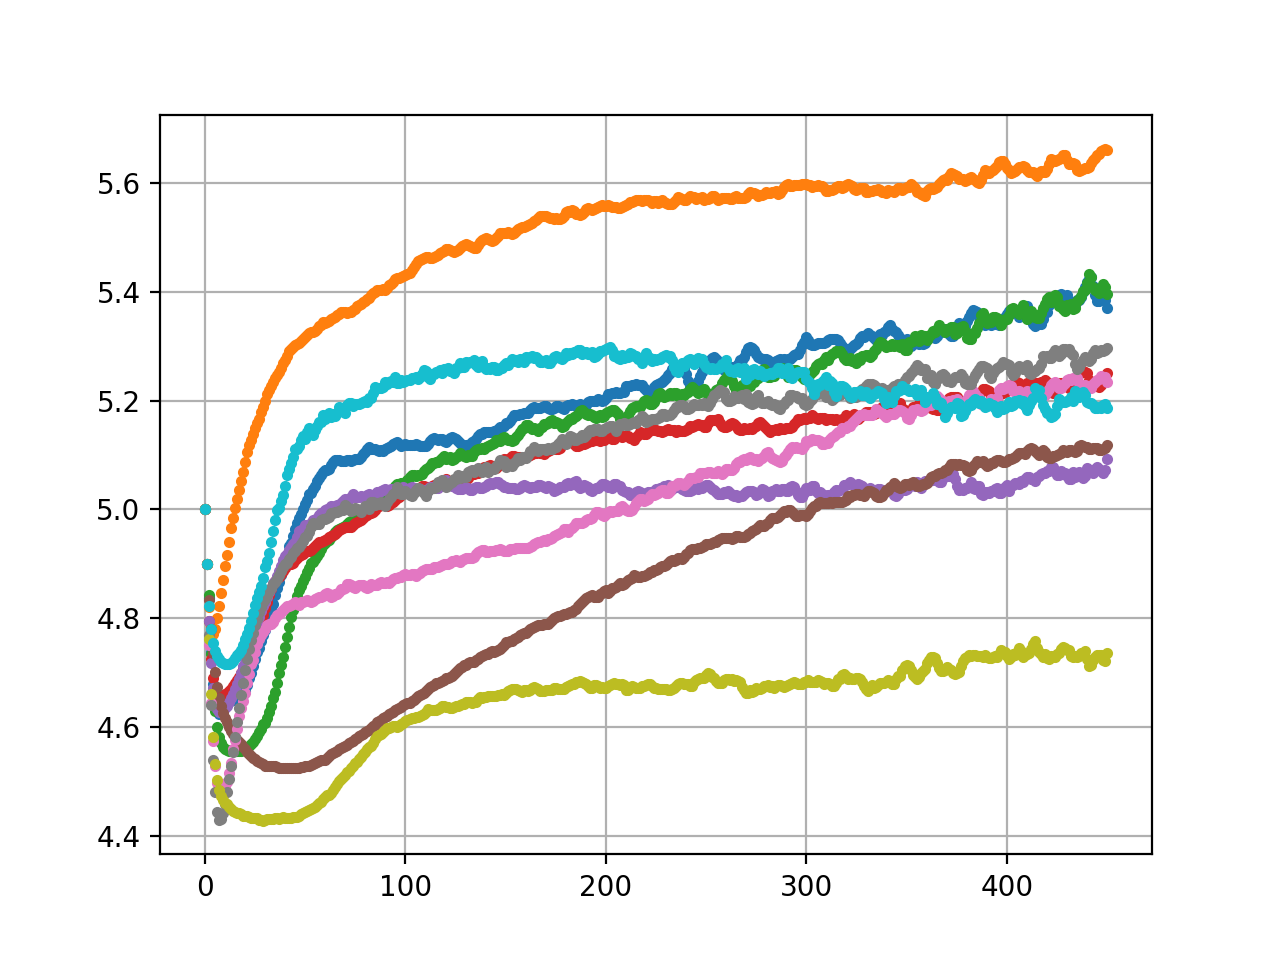

In [25]:
# plot sigma history
for k in fgn_train_res['histories'].keys():
    if 'sigs' in k:
        print(k)
        plt.plot(fgn_train_res['histories'][k][:], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

hidden_layers.4.centers
plotting neurons: [ 8  6 20 31]


<IPython.core.display.Javascript object>


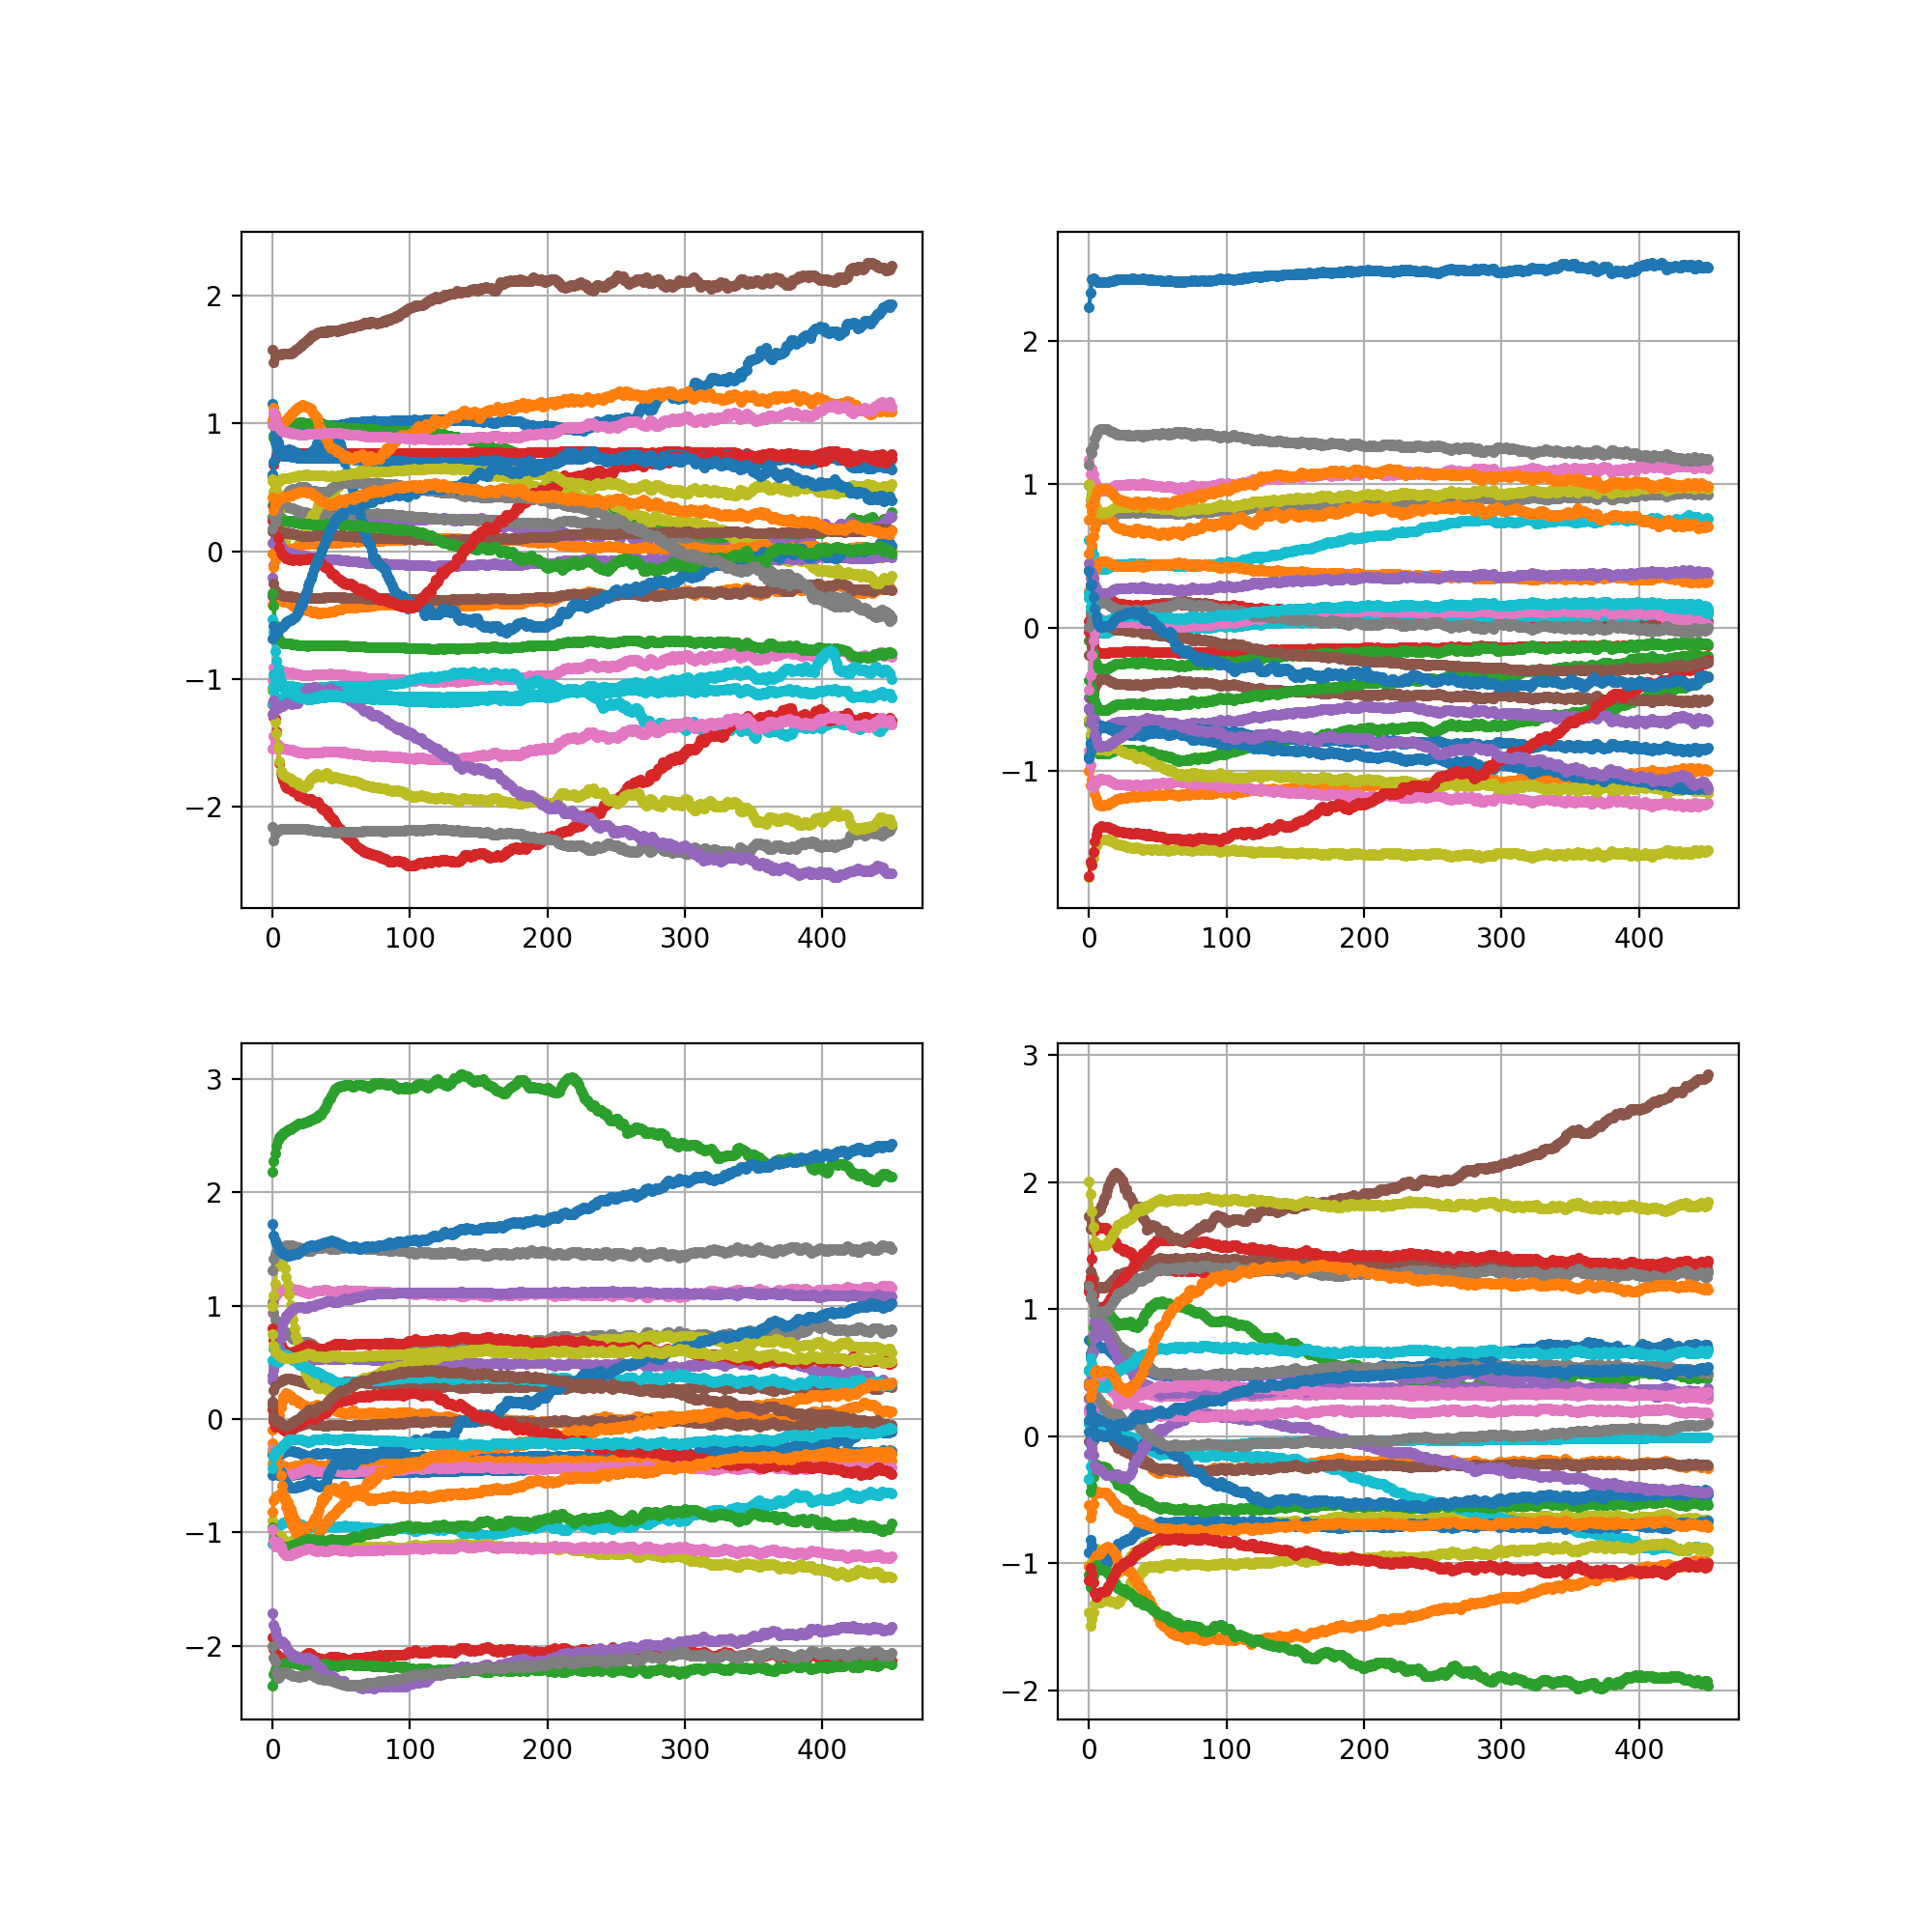

hidden_layers.1.centers
plotting neurons: [ 4 13 26  8]


<IPython.core.display.Javascript object>


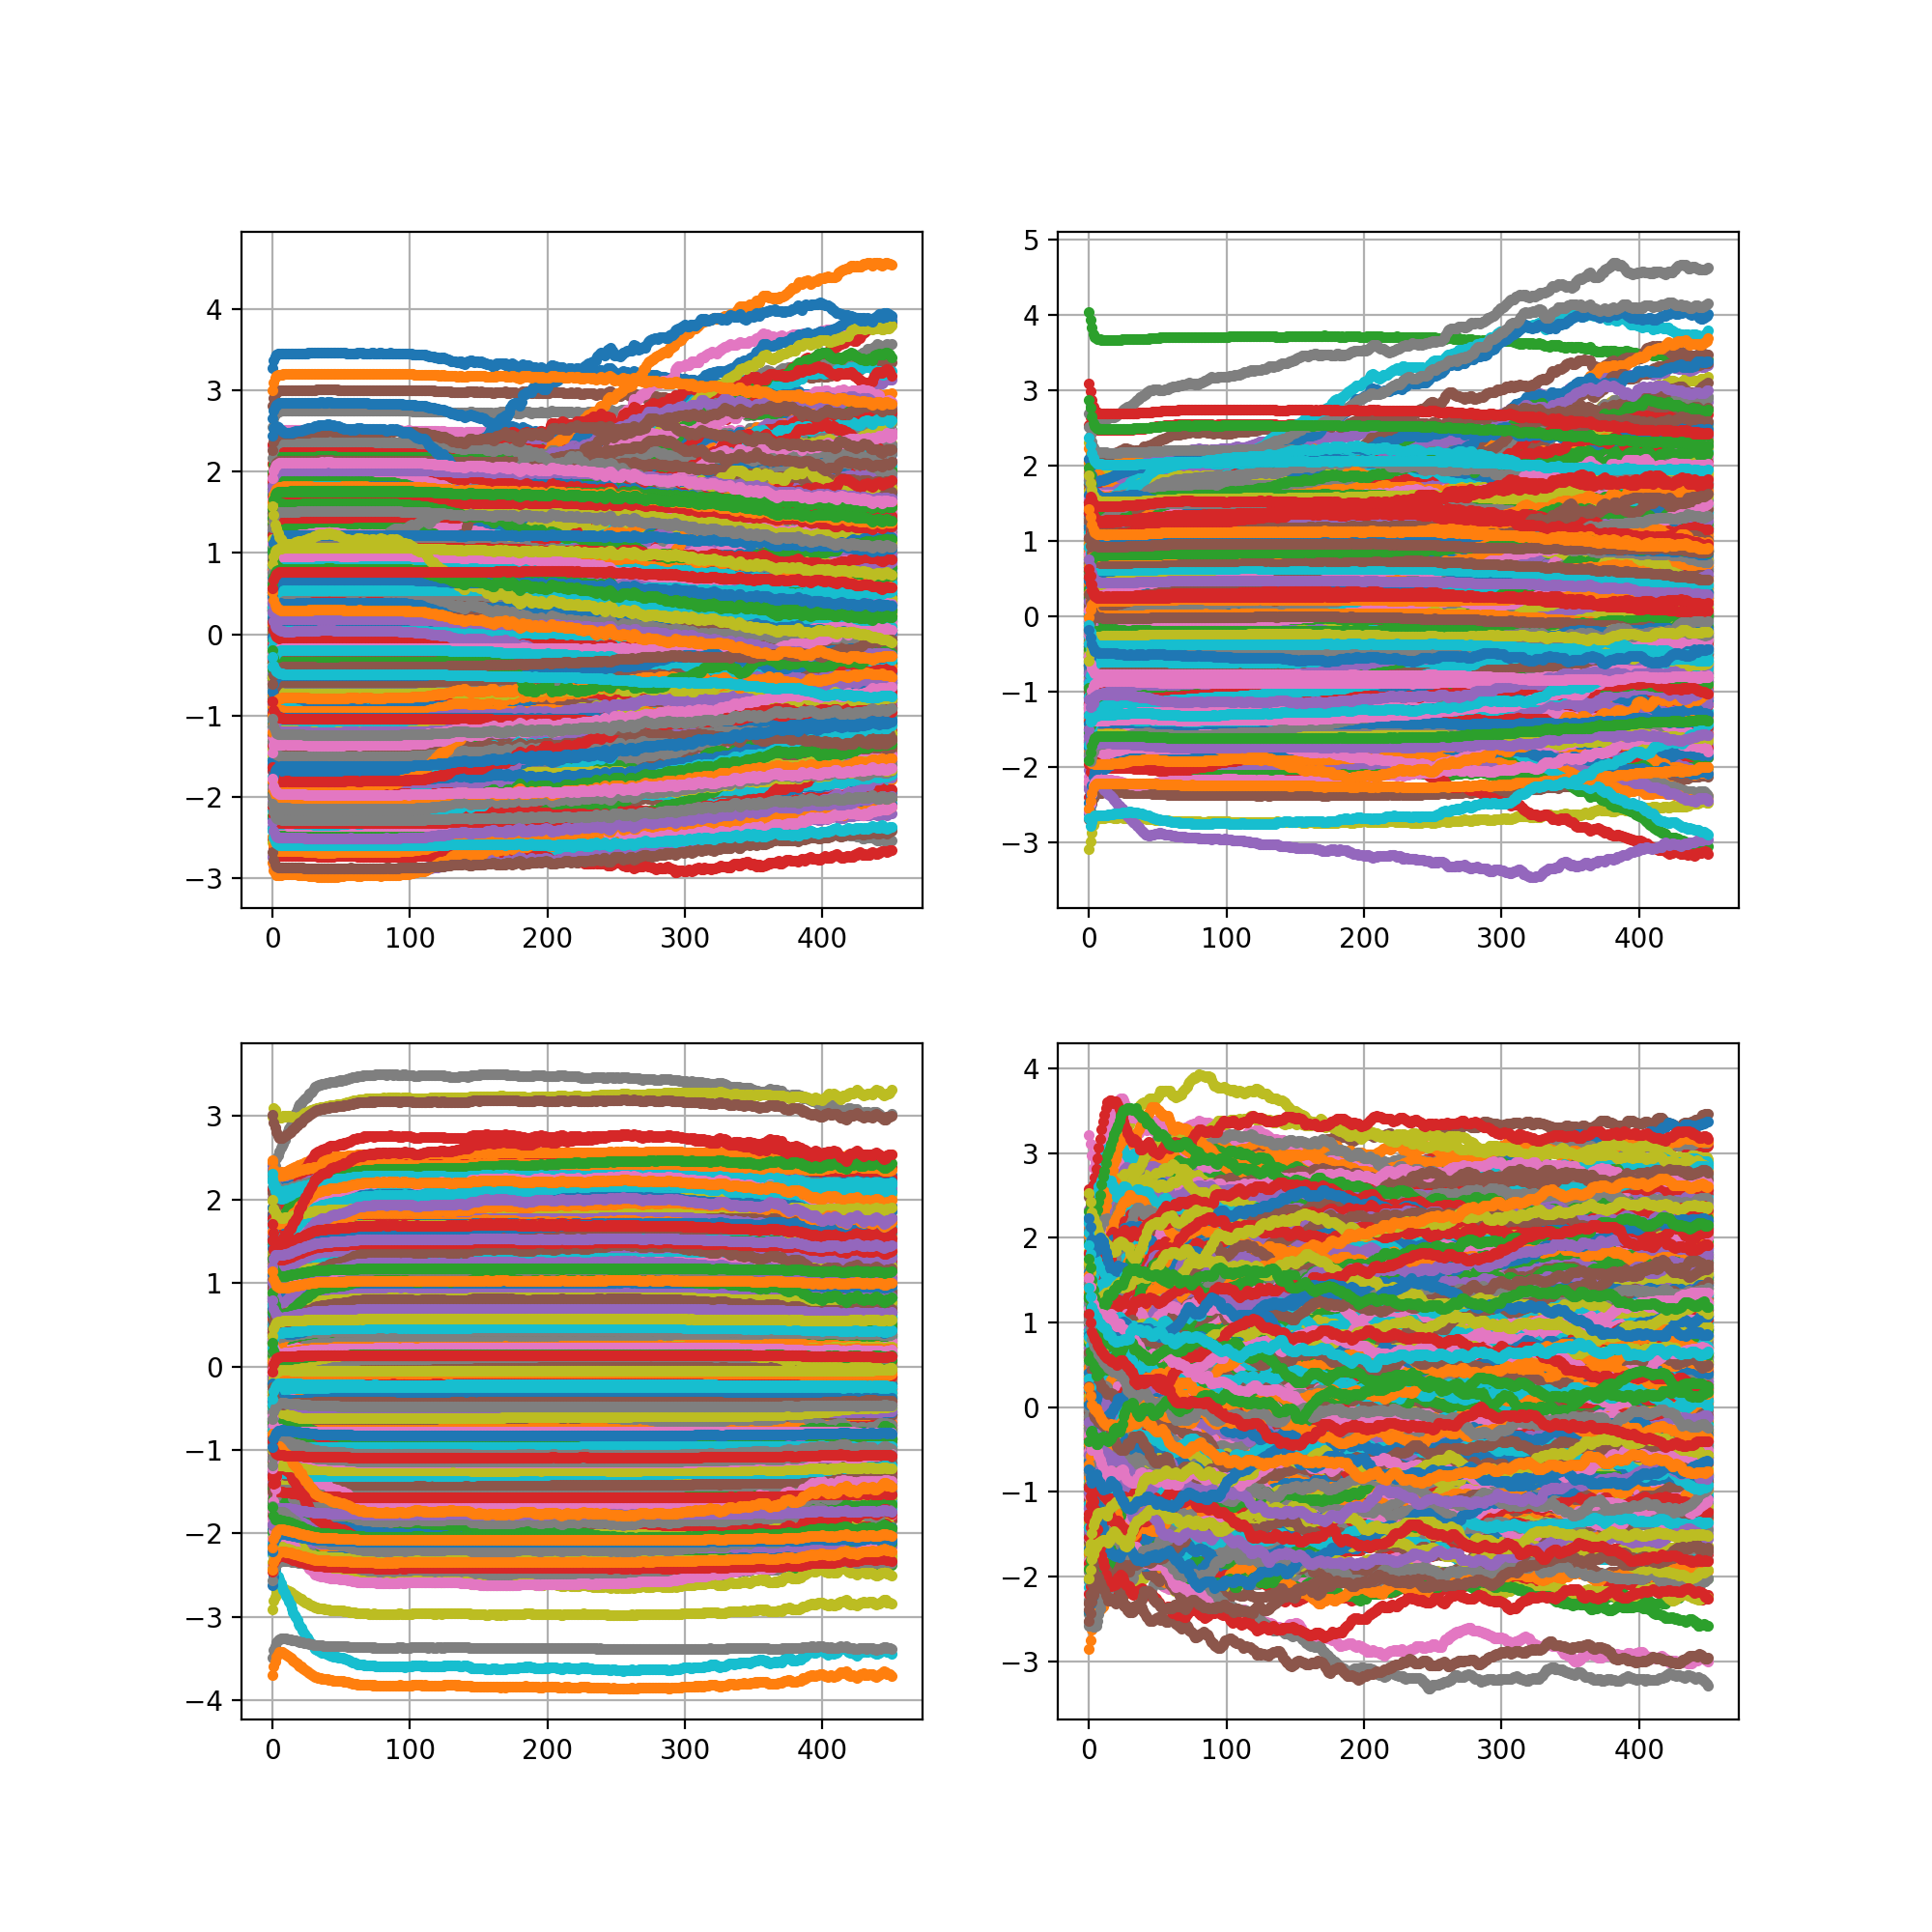

fl.centers
plotting neurons: [0 6 5 1]


<IPython.core.display.Javascript object>


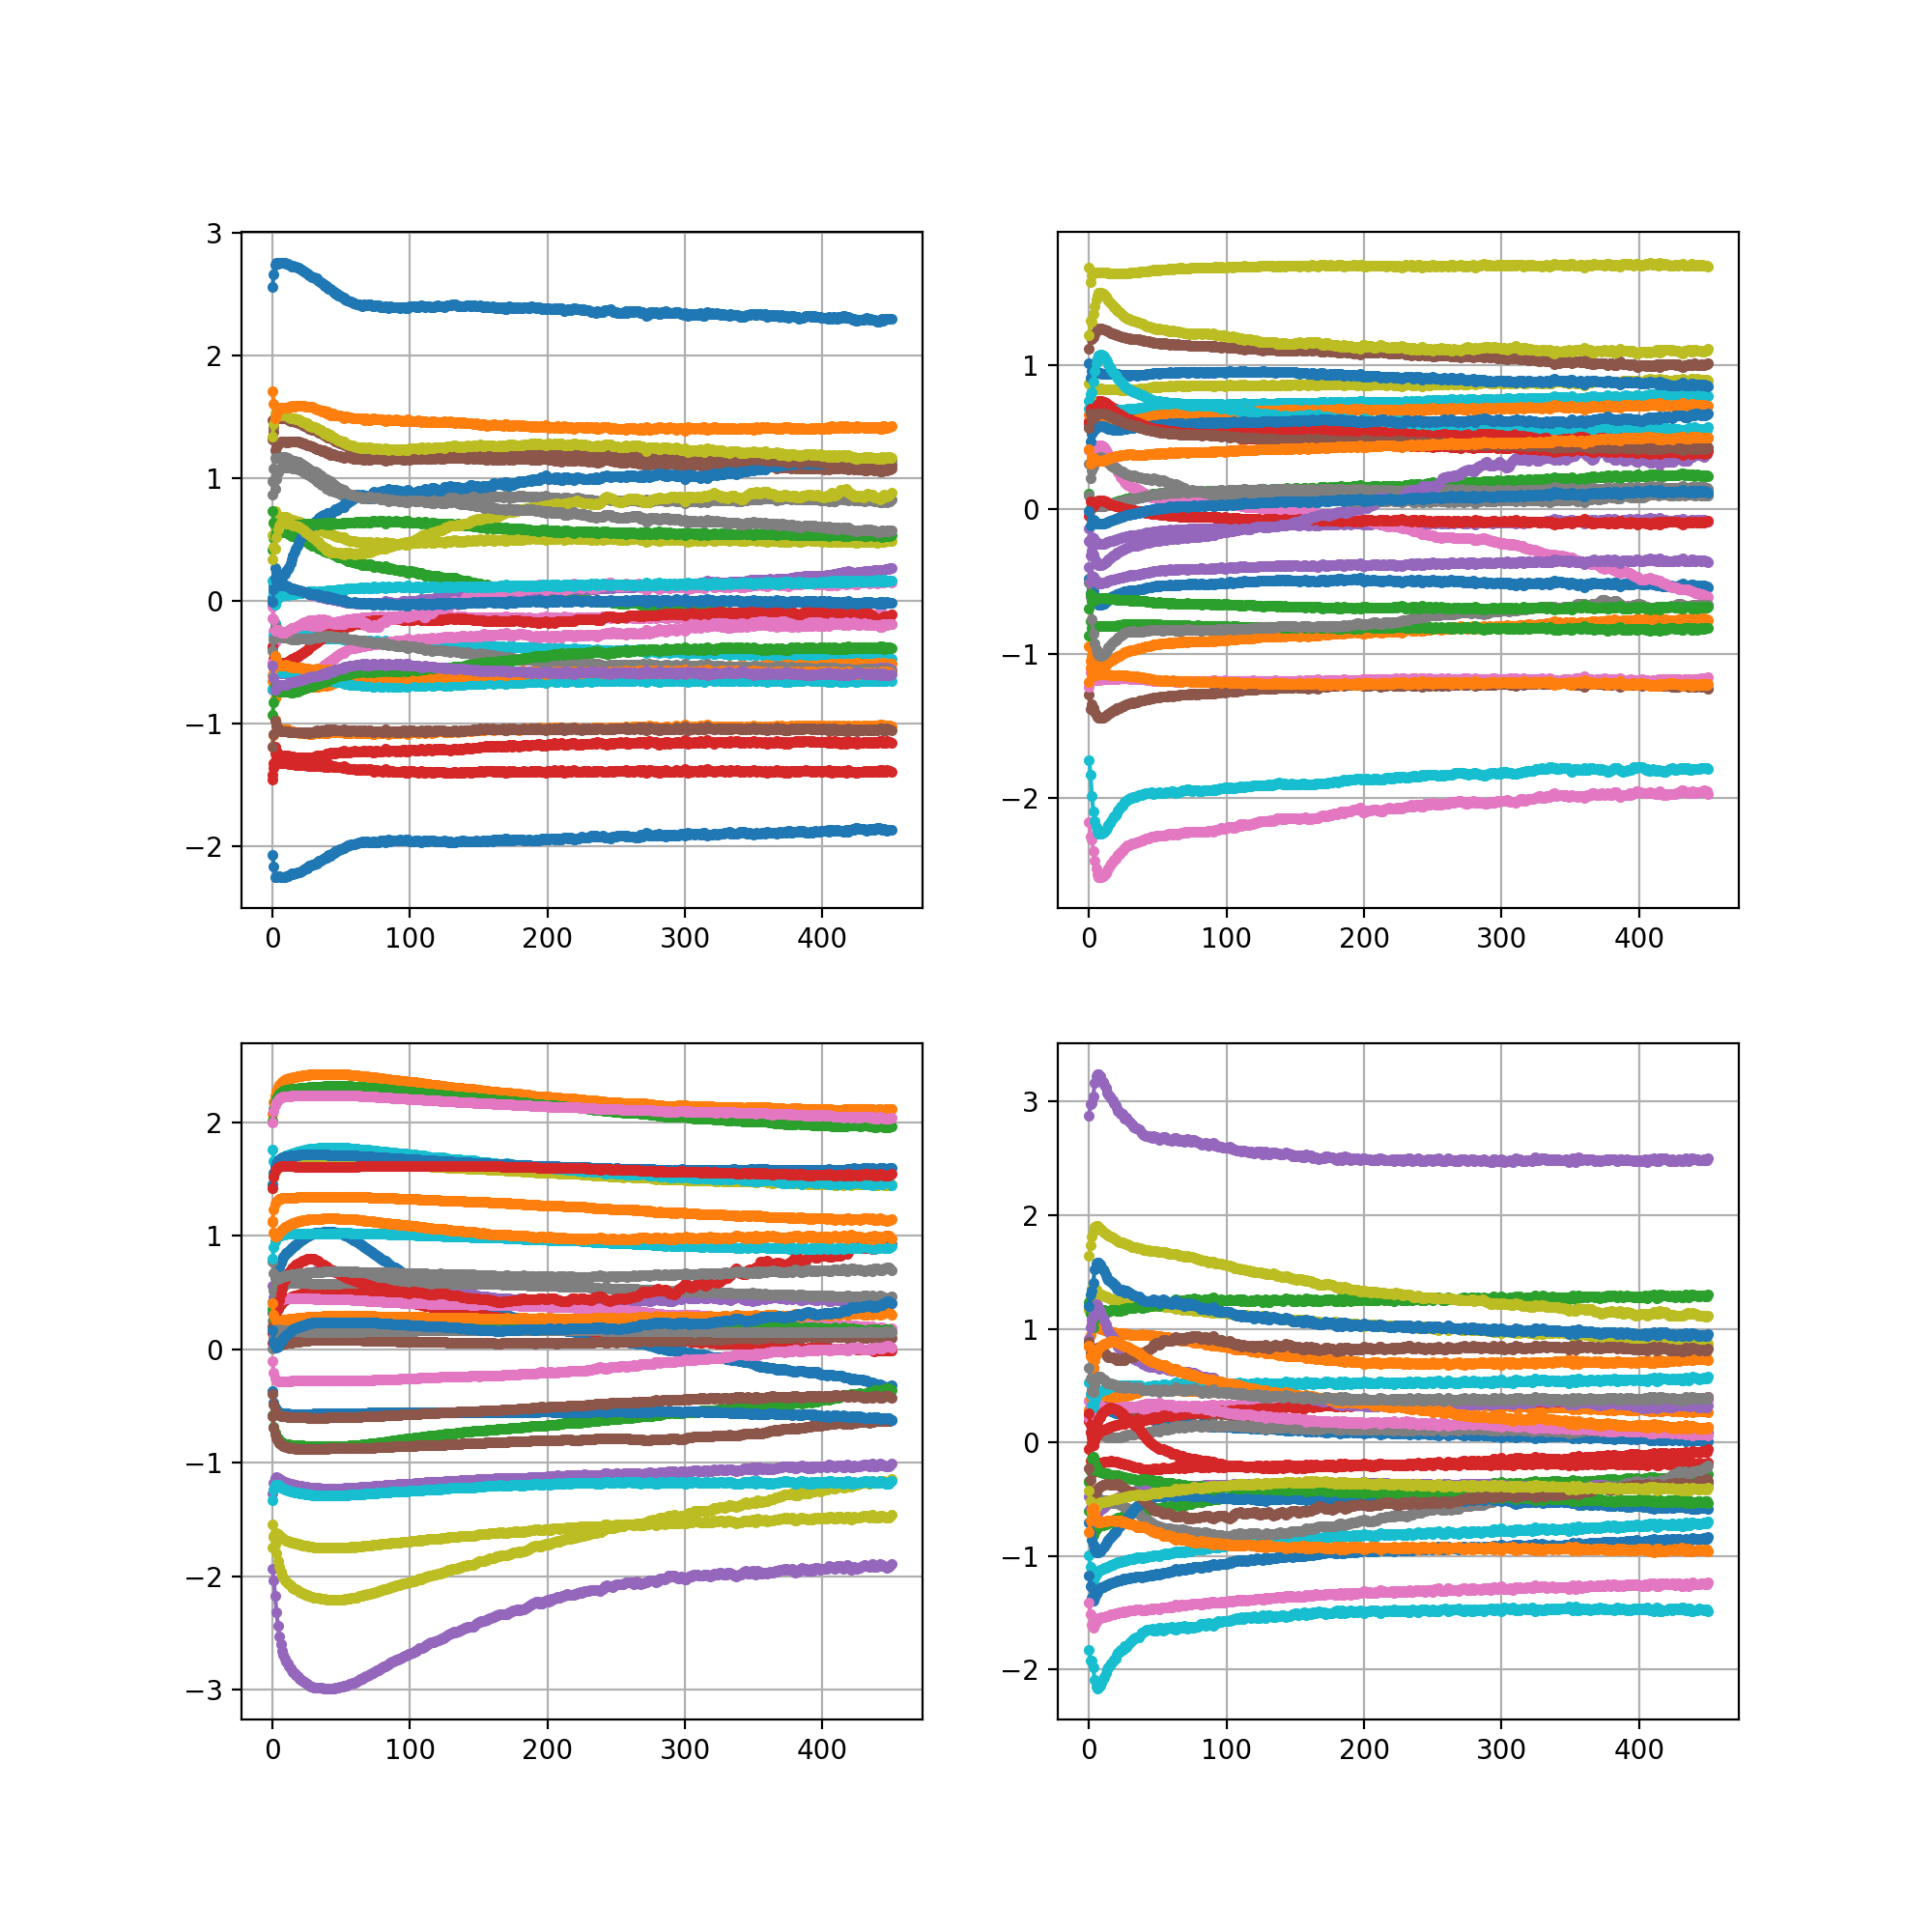

In [26]:
# plot centers history for only some hidden layer neuron

for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(10,10))
        # print(np.shape(fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),4, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,2,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()
            
            

In [27]:
### Next step, train only the sigmas to be minimized

In [28]:
# # new loss with  potentially larger lambda
# # include number of sigs in lmbda?
# t_params = sum(p.numel() for p in fgn_model.parameters() if p.requires_grad)
# print(t_params)
# lmbda = 1.0/(len(mnist_train_loader.dataset)+t_params)
# print(lmbda)


# # training loss function
# def training_loss_func(model, output, target):
    
#     # normal NLL loss
#     nll_loss = F.nll_loss(output, target.long())
# #     print(nll_loss)

#     for p in model.named_parameters():
#         if 'sigs' in p[0]:
#             try:
#                 sig_loss += torch.sum(p[1]**2)
#             except:
#                 sig_loss = torch.sum(p[1]**2)
#     sig_loss = lmbda*sig_loss

#     return 1.0*nll_loss + 1.0*sig_loss

In [29]:
# # new optimizer for this task
# # optimizer = optim.SGD([p for name,p in fgn_model.named_parameters() if p.requires_grad and 'sigs' in name], lr=0.1, momentum=0.1, nesterov=True)
# optimizer = optim.Adam([p for name,p in fgn_model.named_parameters() 
#                         if p.requires_grad 
#                         and 'sigs' in name], 
#                        lr=0.9)


In [30]:
# # train
# train_epochs = 3
# latest_res = th.train(fgn_model, device, mnist_train_loader, training_loss_func, optimizer, 
#                          epochs=train_epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, 
#                          test_loader=mnist_test_loader)


# if len(fgn_train_res) < 0 :
#     for key in fgn_train_res.keys():
#         fgn_train_res[key].extend(latest_res[key])
# else:
#     fgn_train_res = latest_res

In [31]:
# # acc and loss hist
# plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ')
# plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ')
# plt.grid()
# plt.show()

# plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ')
# plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ')
# plt.grid()
# plt.show()

In [32]:
# # plot sigma history
# for k in fgn_train_res['histories'].keys():
#     if 'sigs' in k:
#         print(k)
#         plt.plot(fgn_train_res['histories'][k][:], marker='.', linestyle=' ')
#         plt.grid()
#         plt.show()

In [33]:
# # check that centers havent moved
# # plot centers history for only one neuron
# for k in fgn_train_res['histories'].keys():
#     if 'centers' in k:
#         print(k)
#         # print(np.shape(fgn_train_res['histories'][k]))
#         for n in range(np.shape(fgn_train_res['histories'][k])[1]):
#             print(n)
#             x = fgn_train_res['histories'][k][:,n,:]
#             print(np.shape(x))
#             plt.plot(x, marker='.', linestyle='-')
#             # plt.axis([-3,3, -3, 3])
#             plt.grid()
#             plt.show()
            
#             break

In [34]:
### OLD: part where we test by making the centers of the first layer align with the data
# conclusion: didnt help, not reson ato be the good centers for loss.

In [35]:
# # if it doesn't work well, what if we start with proper centers and sigma?
# fgn_model = th.Feedforward_FGN_net(28*28,10,size).to(device)
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)

In [36]:
# print("Centers of first layer size:", fgn_model.fl.centers.size())
# # centers_from_data
# new_centers = np.mean(mnist_train_loader.dataset.train_data.view(-1, 28*28).numpy(), axis=0)
# print(new_centers.shape)
# # print(torch.Tensor(new_centers))
# # expand to match num of neurons
# new_centers = np.tile(new_centers, [10,1])
# print(new_centers.shape)
# # add some light noise
# # new_centers += np.random.uniform(0,0.0001,new_centers.shape)
# print(new_centers.shape)


# print("Sigmas of first layer size:", fgn_model.fl.sigs.size())
# # sigma from data
# new_sigmas = np.var(mnist_train_loader.dataset.train_data.view(-1, 28*28).numpy())
# print(new_sigmas.shape)
# # expand to match num of neurons
# new_sigmas = np.tile(new_sigmas, [10,])
# print(new_sigmas.shape)
# # add some light noise

# # apply
# fgn_model.state_dict()['fl.centers'].data.copy_(torch.Tensor(new_centers))
# fgn_model.state_dict()['fl.sigs'].data.copy_(torch.Tensor(new_sigmas))

In [37]:
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)

In [38]:
# # reset optimizer
# optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()), momentum=0.6)

In [39]:
# fgn_train_res = th.train(fgn_model, device, mnist_train_loader, training_loss_func, optimizer, epochs=train_epochs, save_hist=2, verbose=True, pred_func=fgn_pred_func, test_loader=mnist_test_loader)

In [40]:
# print("Final layer sigmas:",fgn_model.fl.sigs)
# print("Final layer centers:",fgn_model.fl.centers)